In [2]:
import matplotlib.pyplot as plt
import random
from Arbol import deserialize2, read_tree, deserialize, Node
from parseObj import calcularMatriz
import Arbol as modelo
import torch
import numpy as np
import os
import traceback

In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import random
'''
class Node:
    """
    Class Node
    """
    def __init__(self, value, radius, left=None, right=None):
        self.left = left
        self.data = value
        self.radius = radius  # (x, y) coordinates
        self.right = right'''

def build_graph_from_tree(root, graph=None, parent=None):
    """
    Convert the binary tree into a NetworkX graph.
    """
    if graph is None:
        graph = nx.Graph()  # Undirected graph

    if root is not None:
        graph.add_node(root.data, radius=root.radius)
        if parent:
            graph.add_edge(parent.data, root.data)

        build_graph_from_tree(root.left, graph, root)
        build_graph_from_tree(root.right, graph, root)

    return graph
'''
def rebuild_tree_from_graph(graph, root_value):
    """
    Convert the graph back to a binary tree with the given root value.
    """
    # Use BFS to build the tree
    visited = set()
    queue = [(root_value, None)]  # (current_node, parent_node)
    root = None
    node_map = {}

    while queue:
        current, parent = queue.pop(0)

        if current in visited:
            continue
        visited.add(current)

        # Create the Node if it doesn't exist
        if current not in node_map:
            radius = graph.nodes[current]["radius"]
            node_map[current] = Node(current, radius)

        # Link the current node to its parent
        if parent is not None:
            if node_map[parent].left is None:
                node_map[parent].left = node_map[current]
            elif node_map[parent].right is None:
                node_map[parent].right = node_map[current]

        # Set the root if it's the first node
        if root is None:
            root = node_map[current]

        # Add neighbors to the queue
        for neighbor in graph.neighbors(current):
            if neighbor not in visited:
                queue.append((neighbor, current))

    return root'''

def visualize_tree(root, ax, title="Tree"):
    """
    Visualize the binary tree using coordinates from the radius attribute.
    """
    graph = build_graph_from_tree(root)

    # Extract positions from the radius attribute
    try:
        pos = {node: data["radius"][:2].cpu().tolist() for node, data in graph.nodes(data=True) if torch.mean(data["radius"]) != 0}  # (x, y) positions
    except:
        pos = {node: data["radius"][:2] for node, data in graph.nodes(data=True) if np.mean(data["radius"]) != 0}  # (x, y) positions
    print(pos)
    # Draw the graph
     # Filter nodes and edges based on pos
    nodes_to_plot = list(pos.keys())
    edges_to_plot = [(u, v) for u, v in graph.edges if u in pos and v in pos]

    # Create a subgraph containing only the filtered nodes and edges
    filtered_graph = graph.edge_subgraph(edges_to_plot).copy()

    # Draw the graph

    nx.draw(filtered_graph, pos, with_labels=True, ax=ax, node_size=500, node_color="lightblue", font_size=8, font_color="black")
    # Annotate nodes with their radius (coordinates)
    

    ax.set_title(title)

def limpiarRadios(root):
    if root is not None:
        limpiarRadios(root.left)
        root.radius = [float(r) for r in root.radius]
        limpiarRadios(root.right)

def traversefeatures(root, features):
       
    if root is not None:
        traversefeatures(root.left, features)
        #features.append(root.radius.tolist())
        features.append(root.radius)
        traversefeatures(root.right, features)
        return features
    

def traverseInorder(root):
    if root is not None:
        traverseInorder(root.left)
        print (root.data, root.radius)
        traverseInorder(root.right)

def traversefeaturesSerializado(root, features):
    def post_order(root, features):
        if root:
            post_order(root.left, features)
            post_order(root.right, features)
            features.append(root.radius.cpu().tolist())
                
        #else:
        #    features.append(torch.tensor([0.,0.,0.,0.]))           

    post_order(root, features)
    return features[:-1]  # remove last ,

def normTodos(root, minx, miny, minz, minr, maxx, maxy, maxz, maxr):
    
    if root is not None and torch.mean(root.radius)!=0:
        mx = minx.clone().detach()
        my = miny.clone().detach()
        mz = minz.clone().detach()
        mr = minr.clone().detach()
        Mx = maxx.clone().detach()
        My = maxy.clone().detach()
        Mz = maxz.clone().detach()
        Mr = maxr.clone().detach()
       
        M = max((maxx - minx), (maxy - miny), (maxz - minz))
        root.radius[0] = (root.radius[0] - minx)/M
        root.radius[1] = (root.radius[1] - miny)/M
        root.radius[2] = (root.radius[2] - minz)/M
        root.radius[3] = (root.radius[3])/M
        
        normTodos(root.left, mx, my, mz, mr, Mx, My, Mz, Mr)
        normTodos(root.right, mx, my, mz, mr, Mx, My, Mz, Mr)
        return 

def normalize_features(root):
    features = []
    features = traversefeatures(root, features)
    
    x = [tensor[0] for tensor in features if torch.mean(tensor)!=0]
    y = [tensor[1] for tensor in features if torch.mean(tensor)!=0]
    z = [tensor[2] for tensor in features if torch.mean(tensor)!=0]
    r = [tensor[3] for tensor in features if torch.mean(tensor)!=0]
    
    normTodos(root, min(x), min(y), min(z), min(r), max(x), max(y), max(z), max(r))

    return 

In [37]:
#dir = "resample_Eps01/centerlinesOBJ/" 
#dir = "centerlines" 
dir = "DatosGPT/aneurisk/arboles/p15Eps01/"
trees = os.listdir(dir)
for file in trees:
    try:
        #file = file.split("-")[0]+"-"+file.split("-")[1]#intra
        #file = file.split("_")[0]#aneurisk
        '''
        
        #fileObj = open("resample_Eps01/centerlinesOBJ/" +file.split(".")[0] +"-network.obj")
        fileObj = open("centerlines/" +file.split(".")[0] +"-network.obj")
        #grafo = calcularMatriz(fileObj, "resample_Eps01/radius/" + file.split(".")[0] + "-radius.npy")
        grafo = calcularMatriz(fileObj, "radius/" + file.split(".")[0] + "-radius.npy")'''

        grafo = nx.Graph()
        #serial  = read_tree("DatosGPT/aneurisk/arboles/p15Eps02/"+file.split(".")[0]+".dat") ##INTRA
        serial  = read_tree("DatosGPT/aneurisk/arboles/p15Eps01/"+file) ##ANEURISK
        
        
        root = deserialize(serial)
        root.toGraph( grafo, 0, False, 0)
        

        grafo = grafo.to_undirected()

        nc = 0
        #controlo si tiene ciclos
        if len(nx.cycle_basis(grafo))>0:
            nc = 1
                
        nb = 0
        #controlo si es binario (no hay nodos con mas de 3 edges)
        for nodo in grafo.nodes:
            if len(grafo.edges(nodo))>3:
                nb = 1
                break
    
        
        if nb ==0 and nc == 0: 
            aRecorrer = []
            nodes = list(grafo.nodes)

            numeroNodoInicial = random.choice(nodes)
            
        
            rad = list(grafo.nodes[numeroNodoInicial]['radio'])
            nodoRaiz = modelo.Node( numeroNodoInicial, radius =  rad )

            for vecino in grafo.neighbors( numeroNodoInicial ):
                if vecino != numeroNodoInicial:
                    aRecorrer.append( (vecino, numeroNodoInicial,nodoRaiz ) )
            
            while len(aRecorrer) != 0:
                nodoAAgregar, numeroNodoPadre,nodoPadre = aRecorrer.pop(0)
                radius = list(grafo.nodes[nodoAAgregar]['radio'])
            
                nodoActual = modelo.Node( nodoAAgregar, radius =  radius)
                nodoPadre.agregarHijo( nodoActual )
                for vecino in grafo.neighbors( nodoAAgregar ):
                    if vecino != numeroNodoPadre:
                        aRecorrer.append( (vecino, nodoAAgregar,nodoActual) )

            limpiarRadios(nodoRaiz)
            serial = nodoRaiz.serialize(nodoRaiz)
            #write serialized string to file
            filew = open("DatosGPT/aneurisk/arboles/p15Eps01reroot1/" + file, "w")
            filew.write(serial)
            filew.close() 

            tree = deserialize2(serial)
            normalize_features(tree)
            vector = []
            traversefeaturesSerializado(tree, vector)
            data_np = np.array(vector)
            file_path = 'DatosGPT/aneurisk/numpy/p15Eps01reroot1/' + file.split(".")[0]
            np.save(file_path, data_np)

            

    except:
        print(f"failed with tree {file}")
        #traceback.print_exc()
    

failed with tree 0015_tree.dat
failed with tree 0017_tree.dat
failed with tree 0020_tree.dat
failed with tree 0028a_tree.dat
failed with tree 0028b_tree.dat
failed with tree 0029_tree.dat
failed with tree 0032_tree.dat
failed with tree 0033_tree.dat
failed with tree 0037_tree.dat
failed with tree 0039_tree.dat
failed with tree 0047_tree.dat
failed with tree 0049_tree.dat
failed with tree 0051_tree.dat
failed with tree 0054_tree.dat
failed with tree 0061_tree.dat
failed with tree 0065_tree.dat
failed with tree 0066_tree.dat
failed with tree 0068_tree.dat
failed with tree 0076_tree.dat
failed with tree 0078_tree.dat
failed with tree 0087_tree.dat
failed with tree 0094_tree.dat
failed with tree 0096_tree.dat
failed with tree 099_tree.dat


In [ ]:
root.radius

tensor([0.5033, 0.2567, 0.6981, 0.0300], device='cuda:0')

In [ ]:
nodoRaiz.radius

[0.02082088030874729,
 0.09907933324575424,
 0.057374417781829834,
 0.037670865654945374]

In [ ]:
nodoRaiz.radius = [float(r) for r in nodoRaiz.radius]
nodoRaiz.radius

[0.02082088030874729,
 0.09907933324575424,
 0.057374417781829834,
 0.037670865654945374]

In [ ]:
file

'ArteryObjAN9-7_tree.dat'

FileNotFoundError: [Errno 2] No such file or directory: 'resample_Eps01/Trees/ArteryObjAN9-7_tree_tree.dat'

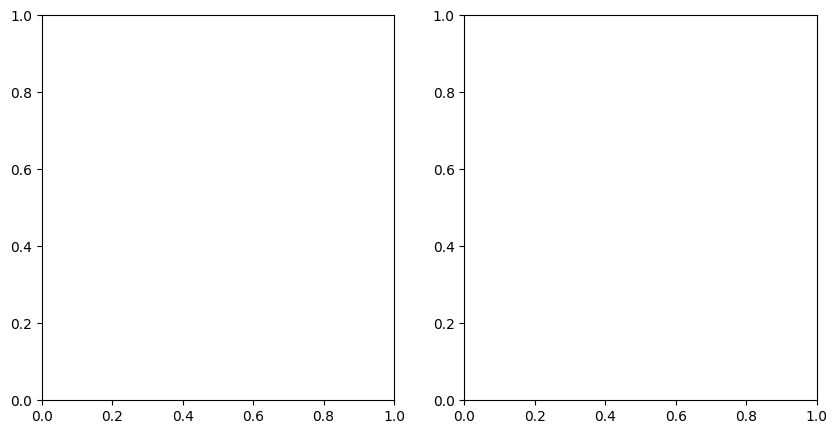

In [ ]:
num_trees = 2
fig, axes = plt.subplots(1, num_trees, figsize=(5 * num_trees, 5))

root = read_tree("resample_Eps01/Trees/" +file.split(".")[0] +"_tree.dat")
print(deserialize2(root))
visualize_tree(deserialize2(root), axes[0], title="Original Tree")

# Plot augmented trees

visualize_tree(nodoRaiz, axes[0 + 1], title=f"Augmented Tree (Root: {numeroNodoInicial})")

plt.tight_layout()
plt.show()

In [ ]:
root

'#;#;#;#;#;#;#;#;#;#;#;#;#;24_[58.6156, -49.6066, -20.4789, 0.35260084227940075];23_[58.8078, -50.4707, -18.0511, 0.3200370311022908];22_[58.6558, -50.7256, -16.9663, 0.373208281411022];21_[58.5553, -50.7261, -16.0293, 0.33486368325433785];20_[58.414, -50.651, -15.2832, 0.38570859494402865];19_[58.0948, -50.4879, -14.5824, 0.41230964110798385];18_[57.44, -50.1267, -13.7757, 0.4276992391242227];17_[56.9894, -49.8801, -13.4584, 0.4284883402108364];16_[55.9543, -49.4213, -13.2184, 0.43582540041758716];15_[55.3857, -49.3188, -13.2185, 0.42360846675038205];14_[54.1007, -49.227, -13.3466, 0.3865573305902247];13_[53.1153, -49.4649, -13.566, 0.44533892284929066];#;#;#;#;#;#;#;#;#;#;#;#;#;0_[44.4617, -50.9078, -23.921, 0.5572607976854856];1_[44.7604, -52.528, -23.0979, 0.5404299835392553];2_[44.8436, -53.0384, -22.6594, 0.5110659380925711];3_[45.1376, -53.4722, -22.0757, 0.4226138885411993];4_[45.3235, -53.9494, -20.9988, 0.513435955192128];5_[45.5517, -53.9353, -19.2721, 0.46114255112851005];6

In [ ]:
deserialize2(root).right.radius

tensor([ 49.3536, -51.9720, -14.2305,   0.4145], device='cuda:0')